In [1]:
from aberrations import make_atm_data, make_1D_vibe_data, make_vibe_params
from observer import make_state_transition_vibe, make_kfilter_vibe, KFilter, make_impulse_from_tt, make_kfilter_turb
from controller import Controller
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal, linalg
from copy import deepcopy
%matplotlib inline

f_sampling = 1000
N_vibe = 1
use_turb = False
steps = 2000
measurement_err = 0.06

rms = lambda data: np.sqrt(np.mean(data ** 2))

In [2]:
if use_turb:
    turb = make_atm_data(steps)[:,0]

In [3]:
true_vibes = np.zeros((N_vibe, steps))
vibe_errs = np.zeros((N_vibe, steps))
vibe_params = np.zeros((N_vibe, 4))
# let's add in process noise so that there's something for Q to fit to!
process_vars = (10**-np.random.uniform(1, 2, (N_vibe,)))**2

In [4]:
for i in range(N_vibe):
    pars = make_vibe_params(N=1)
    true_vibes[i] = make_1D_vibe_data(steps, vib_params=pars, N=1)
    vibe_errs[i] = np.random.normal(0, process_vars[i], (steps,))
    vibe_params[i] = pars
    
vibes = true_vibes + vibe_errs

In [5]:
if use_turb:
    truths = np.sum(vibes, axis=0) + turb
else:
    truths = np.sum(vibes, axis=0)

(1e-07, 29.33540367466483)

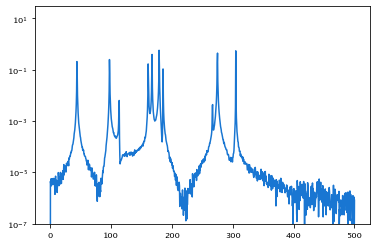

In [6]:
plt.semilogy(*signal.periodogram(truths, fs=f_sampling))
plt.ylim(1e-7)

In [7]:
kfilter_v = make_kfilter_vibe(vibe_params[:,1:3], process_vars)
if use_turb:
    kfilter_t = make_kfilter_turb(make_impulse_from_tt(truths[:500] + np.random.normal(0, measurement_err, (500,))))
    kfilter_t.iters = max(kfilter_t.iters, 500)

Took 366 iterations to get steady-state covariance.


In [8]:
if use_turb:
    kfilter = kfilter_t + kfilter_v
else:
    kfilter = kfilter_v

In [9]:
res, act, pol = Controller('kalman', kfilter).control(truths)

Starting at timestep 20


In [10]:
def show_vibe_control(n=None):
    if n is None:
        truth = truths[kfilter.iters:]
        recorded = np.sum(vibes_recorded, axis=0)[kfilter.iters:]
    else:
        truth = vibes[n][kfilter.iters:]
        recorded = vibes_recorded[n][kfilter.iters:]
    plt.plot(truth, label='Truths')
    plt.plot(recorded, label='Kalman filtered')
    plt.plot(truth - recorded, label='Residual')
    plt.legend()
    plt.title("Control with white driving noise, rms = " + str(rms(truth - recorded)))
    plt.show()
    return truth, recorded

def show_overall_control():
    truth = truths[kfilter.iters:]
    recorded = kfiltered[kfilter.iters:]
    plt.plot(truth, label='Truths')
    plt.plot(recorded, label='Kalman filtered')
    plt.plot(truth - recorded, label='Residual')
    plt.legend()
    plt.title("Control with white driving noise, rms = " + str(rms(truth - recorded)))
    plt.show()
    return truth, recorded

(1e-10, 102.27377087381286)

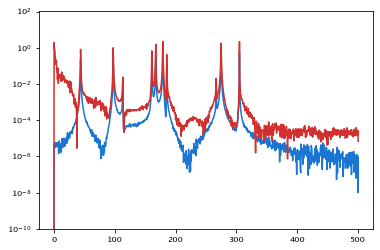

In [11]:
f, Pt = signal.periodogram(pol, fs=f_sampling)
f, Pres = signal.periodogram(res, fs=f_sampling)
plt.semilogy(f, Pt)
plt.semilogy(f, Pres)
plt.ylim(1e-10)